In [1]:
import os
import warnings
import datetime

import numpy as np
import pandas as pd

import matplotlib.dates as mdates
from matplotlib import pyplot
from github import Github

import sklearn.linear_model

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
git = Github(os.getenv('GH_TOKEN'))
repo = git.get_repo('pr0nstar/covid19-data')

##### Mortalidad

In [3]:
mortality_dir = repo.get_contents('raw/mortality')
mortality_file = {
    os.path.basename(_.path): _ for _ in mortality_dir
}['south.america.subnational.mortality.csv']

In [4]:
df = pd.read_csv(mortality_file.download_url)
df['date'] = pd.to_datetime(df['date'])

geo_codes = {'PY-{}'.format(_):'PY-0{}'.format(_) for _ in range(1, 10)}

df['adm1_isocode'] = df['adm1_isocode'].replace(geo_codes)
df = df.set_index(['iso_code', 'adm1_isocode', 'date'])
df = df.sort_index()

df.head(1)

,,,country_name,adm1_name,frequency,deaths
iso_code,adm1_isocode,date,,,,
BO,BO-B,2019-01-01,Bolivia,Beni,monthly,131


In [5]:
# Align Colombia
df_co = df.loc[['CO']].reset_index(level='date')
df_co['date'] = df_co['date'] - pd.DateOffset(days=1)
df_co = df_co.set_index('date', append=True)

df = df.drop('CO', level='iso_code')
df = pd.concat([df, df_co])

In [6]:
# https://en.wikipedia.org/wiki/2017_Mocoa_landslide
df.loc[('CO', 'CO-PUT', '2017-03-26'), 'deaths'] = 24

In [7]:
#### Drop Peru Lambayaque 2019
df_pe_lam = df.xs(('PE', 'PE-LAM'), drop_level=False).reset_index(level='date')
df_pe_lam = df_pe_lam[df_pe_lam['date'] < '2019'].set_index('date', append=True)

df = df.drop(df_pe_lam.index)

#### Drop Peru Ayacucho 2017
df_pe_lam = df.xs(('PE', 'PE-AYA'), drop_level=False).reset_index(level='date')
df_pe_lam = df_pe_lam[df_pe_lam['date'] < '2018'].set_index('date', append=True)

df = df.drop(df_pe_lam.index)

In [8]:
#### Drop Brasil 2018
df_br = df.loc[['BR']].reset_index(level='date')
df_br = df_br[df_br['date'] < '2019'].set_index('date', append=True)

df = df.drop(df_br.index)

In [9]:
location_df = df[['country_name', 'adm1_name']]
location_df = location_df.droplevel([0, 2])
location_df = location_df.drop_duplicates()

location_df.head(1)

,country_name,adm1_name
adm1_isocode,,
BO-B,Bolivia,Beni


##### Fallecimientos COVID

In [10]:
paho_dir = repo.get_contents('raw/paho')
paho_dir_dict = {
    os.path.basename(_.path): _ for _ in paho_dir
}
paho_deaths_file = paho_dir_dict['deaths.timeline.csv']
paho_deaths_patch_file = paho_dir_dict['deaths.timeline.daily.patch.csv']

In [11]:
paho_df = pd.read_csv(paho_deaths_file.download_url, header=[0, 1], index_col=0)
paho_df.index = pd.to_datetime(paho_df.index)

paho_df = paho_df.asfreq('D')
paho_df = paho_df.replace(0, np.nan)

paho_patch_df = pd.read_csv(paho_deaths_patch_file.download_url, header=[0, 1], index_col=0)
paho_patch_df.index = pd.to_datetime(paho_patch_df.index)
paho_patch_df = paho_patch_df.drop('2021-10-02')

paho_df.update(paho_patch_df)

paho_df.head(1)

ISO3_CODE      ABW  ARG                                          ...  VEN  \
ADM1_ISOCODE AW-01 AR-A AR-B AR-C AR-D AR-E AR-F AR-G AR-H AR-J  ... VE-X   
DATA_DATE                                                        ...        
2020-01-21     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   

ISO3_CODE                VGB                     VIR              
ADM1_ISOCODE VE-Y VE-Z VG-01 VG-02 VG-04 VG-05 VI-01 VI-02 VI-03  
DATA_DATE                                                         
2020-01-21    NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[1 rows x 624 columns]

In [12]:
# Patch Huanuco
paho_df.loc['2021-08-22':'2021-09-24', ('PER', 'PE-HUC')] = np.nan

In [13]:
covid_deaths_df = pd.DataFrame([])

for country_key, country_data in paho_df.groupby(level=0, axis=1):
    if country_data.iloc[-1].sum() > 100:
        country_data = country_data.drop_duplicates().asfreq('D')
        country_data = country_data.loc[:, (~country_data.isna()).sum() > 1]
        country_data = country_data.interpolate('from_derivatives', limit_area='inside')
    
    covid_deaths_df = pd.concat([covid_deaths_df, country_data], axis=1)

In [14]:
for _ in range(3):
    covid_deaths_df[(covid_deaths_df.diff() < 0).shift(-1).fillna(False)] = np.nan
    covid_deaths_df = covid_deaths_df.interpolate('from_derivatives', limit_area='inside')
    
for _ in range(3):
    covid_deaths_df[covid_deaths_df.diff() < 0] = np.nan
    covid_deaths_df = covid_deaths_df.interpolate('from_derivatives', limit_area='inside')
    
covid_deaths_df = covid_deaths_df.round().dropna(how='all')
covid_deaths_df = covid_deaths_df.diff().fillna(covid_deaths_df)
covid_deaths_df = covid_deaths_df.resample('W').sum()

covid_deaths_df.head(1)

ISO3_CODE      ABW  ARG                                          ...  VEN  \
ADM1_ISOCODE AW-01 AR-A AR-B AR-C AR-D AR-E AR-F AR-G AR-H AR-J  ... VE-X   
DATA_DATE                                                        ...        
2020-03-01     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   

ISO3_CODE                VGB                     VIR              
ADM1_ISOCODE VE-Y VE-Z VG-01 VG-02 VG-04 VG-05 VI-01 VI-02 VI-03  
DATA_DATE                                                         
2020-03-01    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[1 rows x 624 columns]

##### Curvas

In [15]:
def stylize_ax(ax, label, loc='upper left'):
    if type(ax) == np.ndarray:
        [stylize_ax(_, loc) for _ in ax]
        return
    
    ax.grid(
        b=True, 
        color='DarkTurquoise', 
        alpha=0.2, 
        linestyle=':', 
        linewidth=2
    )
    
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(
        lines[:1], 
        [label], 
        loc=loc, 
        framealpha=.3,
        fontsize='large'
    )
    
def year_start(year):
    fourth_jan = datetime.date(year, 1, 4)
    delta = datetime.timedelta(fourth_jan.isoweekday() - 1)
    
    return fourth_jan - delta

def align_precovid(df):
    # https://github.com/dkobak/excess-mortality/blob/main/all-countries.ipynb
    base_df = df.loc[:'2019']
    base_df_index = base_df.index.isocalendar()
    
    base_df = base_df.to_frame().set_index([
        base_df_index.year, base_df_index.week
    ])[df.name]
    
    base_years = base_df.index.get_level_values(0).values.reshape(-1 ,1)
    base_years_n = len(np.unique(base_years))

    onehot = np.concatenate([np.eye(52) for _ in range(base_years_n)])
    predictors = np.concatenate((base_years, onehot), axis=1)

    reg = sklearn.linear_model.LinearRegression(fit_intercept=False).fit(
        predictors, base_df.values
    )

    baseline = reg.predict(
        np.concatenate((np.ones((52, 1)) * 2020, np.eye(52)), axis=1)
    )
    
    fbase_df = pd.DataFrame([])
    for year in df.loc['2020':].index.year.unique():
        indexed_base_df = pd.Series(baseline)
        base_df_index = pd.date_range(
            start=year_start(year) + datetime.timedelta(1), 
            end=year_start(year + 1), 
            freq='W'
        )
        if len(base_df_index) == 53:
            indexed_base_df.loc[53] = indexed_base_df.iloc[-1]
            
        indexed_base_df.index = base_df_index
        fbase_df = pd.concat([fbase_df, indexed_base_df])
        
        
    return fbase_df[0].rename(df.name)[:df.index[-1]]
    
def do_plot(covid_mortality_df, registered_covid_df, ax=None):    
    pre_covid_df = align_precovid(covid_mortality_df)

    if ax is None:
        fig, ax = pyplot.subplots(figsize=(50/2.54, 25/2.54))

    pre_covid_df.plot(
        color='tab:blue', 
        label='Promedio',
        ax=ax
    )

    during_covid_df = covid_mortality_df.loc['2020':]
    ax = during_covid_df.plot(
        ax=ax, 
        color='midnightblue', 
        label='Fallecimientos', 
        linewidth=2
    )

    registered_covid_df_weekly = registered_covid_df.copy()
    registered_covid_df_weekly = registered_covid_df_weekly[
        registered_covid_df_weekly.replace(0, np.nan).first_valid_index():
    ]
    registered_covid_df_weekly = registered_covid_df_weekly.sort_index()
    registered_covid_df_weekly = registered_covid_df_weekly.resample('W').mean().fillna(0)

    registered_covid_df_weekly = registered_covid_df_weekly + pre_covid_df
    registered_covid_df_weekly = registered_covid_df_weekly.loc[:pre_covid_df.index[-1]]
    
    registered_covid_df_weekly.plot(
        ax=ax, label='COVID confirmado', color='red'
    )
    ax.fill_between(
        registered_covid_df_weekly.index, 
        registered_covid_df_weekly, 
        pre_covid_df, 
        color='red', 
        alpha=.3
    )

    if len(pre_covid_df) > 1:
        std = pre_covid_df.std()
        (registered_covid_df_weekly + std).plot(
            ax=ax, linestyle=':', color='tab:red', label='Max'
        )

        (pre_covid_df - std).plot(
            ax=ax, linestyle=':', color='tab:blue', label='Min'
        )
        
    max_death = covid_mortality_df.max() * 1.1

    ax.set_xlim(during_covid_df.index.min(), during_covid_df.index.max())
    ax.set_ylim(0, max_death)
    
    registered_covid_df_weekly_overflow = registered_covid_df_weekly[
        registered_covid_df_weekly > (max_death * 1.1)
    ]
    
    for registered_date, registered_death in registered_covid_df_weekly_overflow.iteritems():
        ax.annotate(
            int(registered_death), 
            xy=(registered_date, 1), xytext=(0, -7), 
            ha='center',
            xycoords=('data', 'axes fraction'), 
            textcoords='offset points',
            bbox={
                'edgecolor': 'none',
                'facecolor': 'white', 
                'alpha': 0.5
            }
        )
    
    label = location_df.loc[covid_mortality_df.name]['adm1_name']
    country_prefix = covid_mortality_df.name.split('-')[0]
    stylize_ax(ax, '{}-{:25.25}'.format(country_prefix, label))
    
    ax.set(frame_on=False)
    
    return ax

In [16]:
mortality_df = pd.DataFrame([])
today = pd.to_datetime('today').round('d')

for iso_code, country_mortality_df in df.groupby(level=0):
    country_mortality_df = country_mortality_df.droplevel(0)
    country_data_freq = country_mortality_df['frequency'].iloc[0]

    if country_data_freq == 'daily':
        country_mortality_df = country_mortality_df.groupby([
            pd.Grouper(level='adm1_isocode'),
            pd.Grouper(level='date', freq='D')
        ])['deaths'].mean()
        country_mortality_df = country_mortality_df.interpolate('linear')
        country_mortality_df = country_mortality_df.unstack(level=0)
        country_mortality_df = country_mortality_df.resample('W').sum(min_count=1)

    elif country_data_freq == 'monthly':
        country_mortality_df = country_mortality_df['deaths'].unstack(level=0)
        
        country_mortality_df_index = country_mortality_df.iloc[-1:].resample('W').mean().index
        country_mortality_df_index_diff = (
            (country_mortality_df_index + pd.offsets.MonthBegin(1)) - country_mortality_df_index
        )
        country_mortality_df_index_diff = np.floor(
            country_mortality_df_index_diff / pd.Timedelta(days=7)
        )[0] * 7 + country_mortality_df_index.day[0] - 1

        country_mortality_df_index = country_mortality_df.index[0]
        country_mortality_df.index = country_mortality_df.index + pd.DateOffset(
            days=country_mortality_df_index_diff
        )

        country_mortality_df.loc[
            pd.to_datetime(year_start(country_mortality_df_index.year)) - pd.DateOffset(days=1)
        ] = 0
        country_mortality_df = country_mortality_df.sort_index()

        if country_mortality_df.index[-1] > today:
            country_mortality_df = country_mortality_df.rename(
                index={country_mortality_df.index[-1]: today - pd.DateOffset(days=1)}
            )
            country_mortality_df = country_mortality_df.groupby(
                level=country_mortality_df.index.name
            ).sum()

        country_mortality_df = country_mortality_df.cumsum().asfreq('d')
        country_mortality_df = country_mortality_df.interpolate('from_derivatives')
        country_mortality_df = country_mortality_df.diff().dropna().resample('W').sum()

    else:
        country_mortality_df = country_mortality_df['deaths'].unstack(level=0)
        
    mortality_df = pd.concat([mortality_df, country_mortality_df], axis=1)
    
mortality_df = mortality_df.loc['2017-01-02':].dropna(how='all').round()
mortality_df.head(1)

adm1_isocode,BO-B,BO-C,BO-H,BO-L,BO-N,BO-O,BO-P,BO-S,BO-T,BR-AC,...,UY-MO,UY-PA,UY-RN,UY-RO,UY-RV,UY-SA,UY-SJ,UY-SO,UY-TA,UY-TT
date,,,,,,,,,,,,,,,,,,,,,
2017-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,285.0,18.0,6.0,16.0,19.0,17.0,14.0,12.0,16.0,7.0


In [17]:
covid_deaths_df = covid_deaths_df.T.droplevel(0)
covid_deaths_df = covid_deaths_df.loc[
    mortality_df.columns
].T

In [18]:
mortality_df_limit = mortality_df.apply(lambda _: _.last_valid_index())
# right censoring
mortality_df_limit = mortality_df_limit - pd.DateOffset(weeks=2)

In [19]:
covid_deaths_df_agg = covid_deaths_df.apply(lambda _: _[:mortality_df_limit[_.name]])

mortality_df_agg = mortality_df.copy()
mortality_df_agg = mortality_df_agg.apply(lambda _: align_precovid(_.dropna()))

mortality_current_df_agg = mortality_df['2020':].apply(
    lambda _: _[covid_deaths_df_agg.index[0]:mortality_df_limit[_.name]]
).sum()

sub_registered_mortality_rank = (mortality_df_agg + covid_deaths_df_agg).dropna(how='all').sum()
sub_registered_mortality_rank = (sub_registered_mortality_rank / mortality_current_df_agg).sort_values()

In [20]:
mortality_df = mortality_df[sub_registered_mortality_rank.index]
mortality_df = mortality_df[mortality_df.columns[(mortality_df > 70).any()]]
mortality_df = mortality_df.round()

mortality_df.index.name = ''

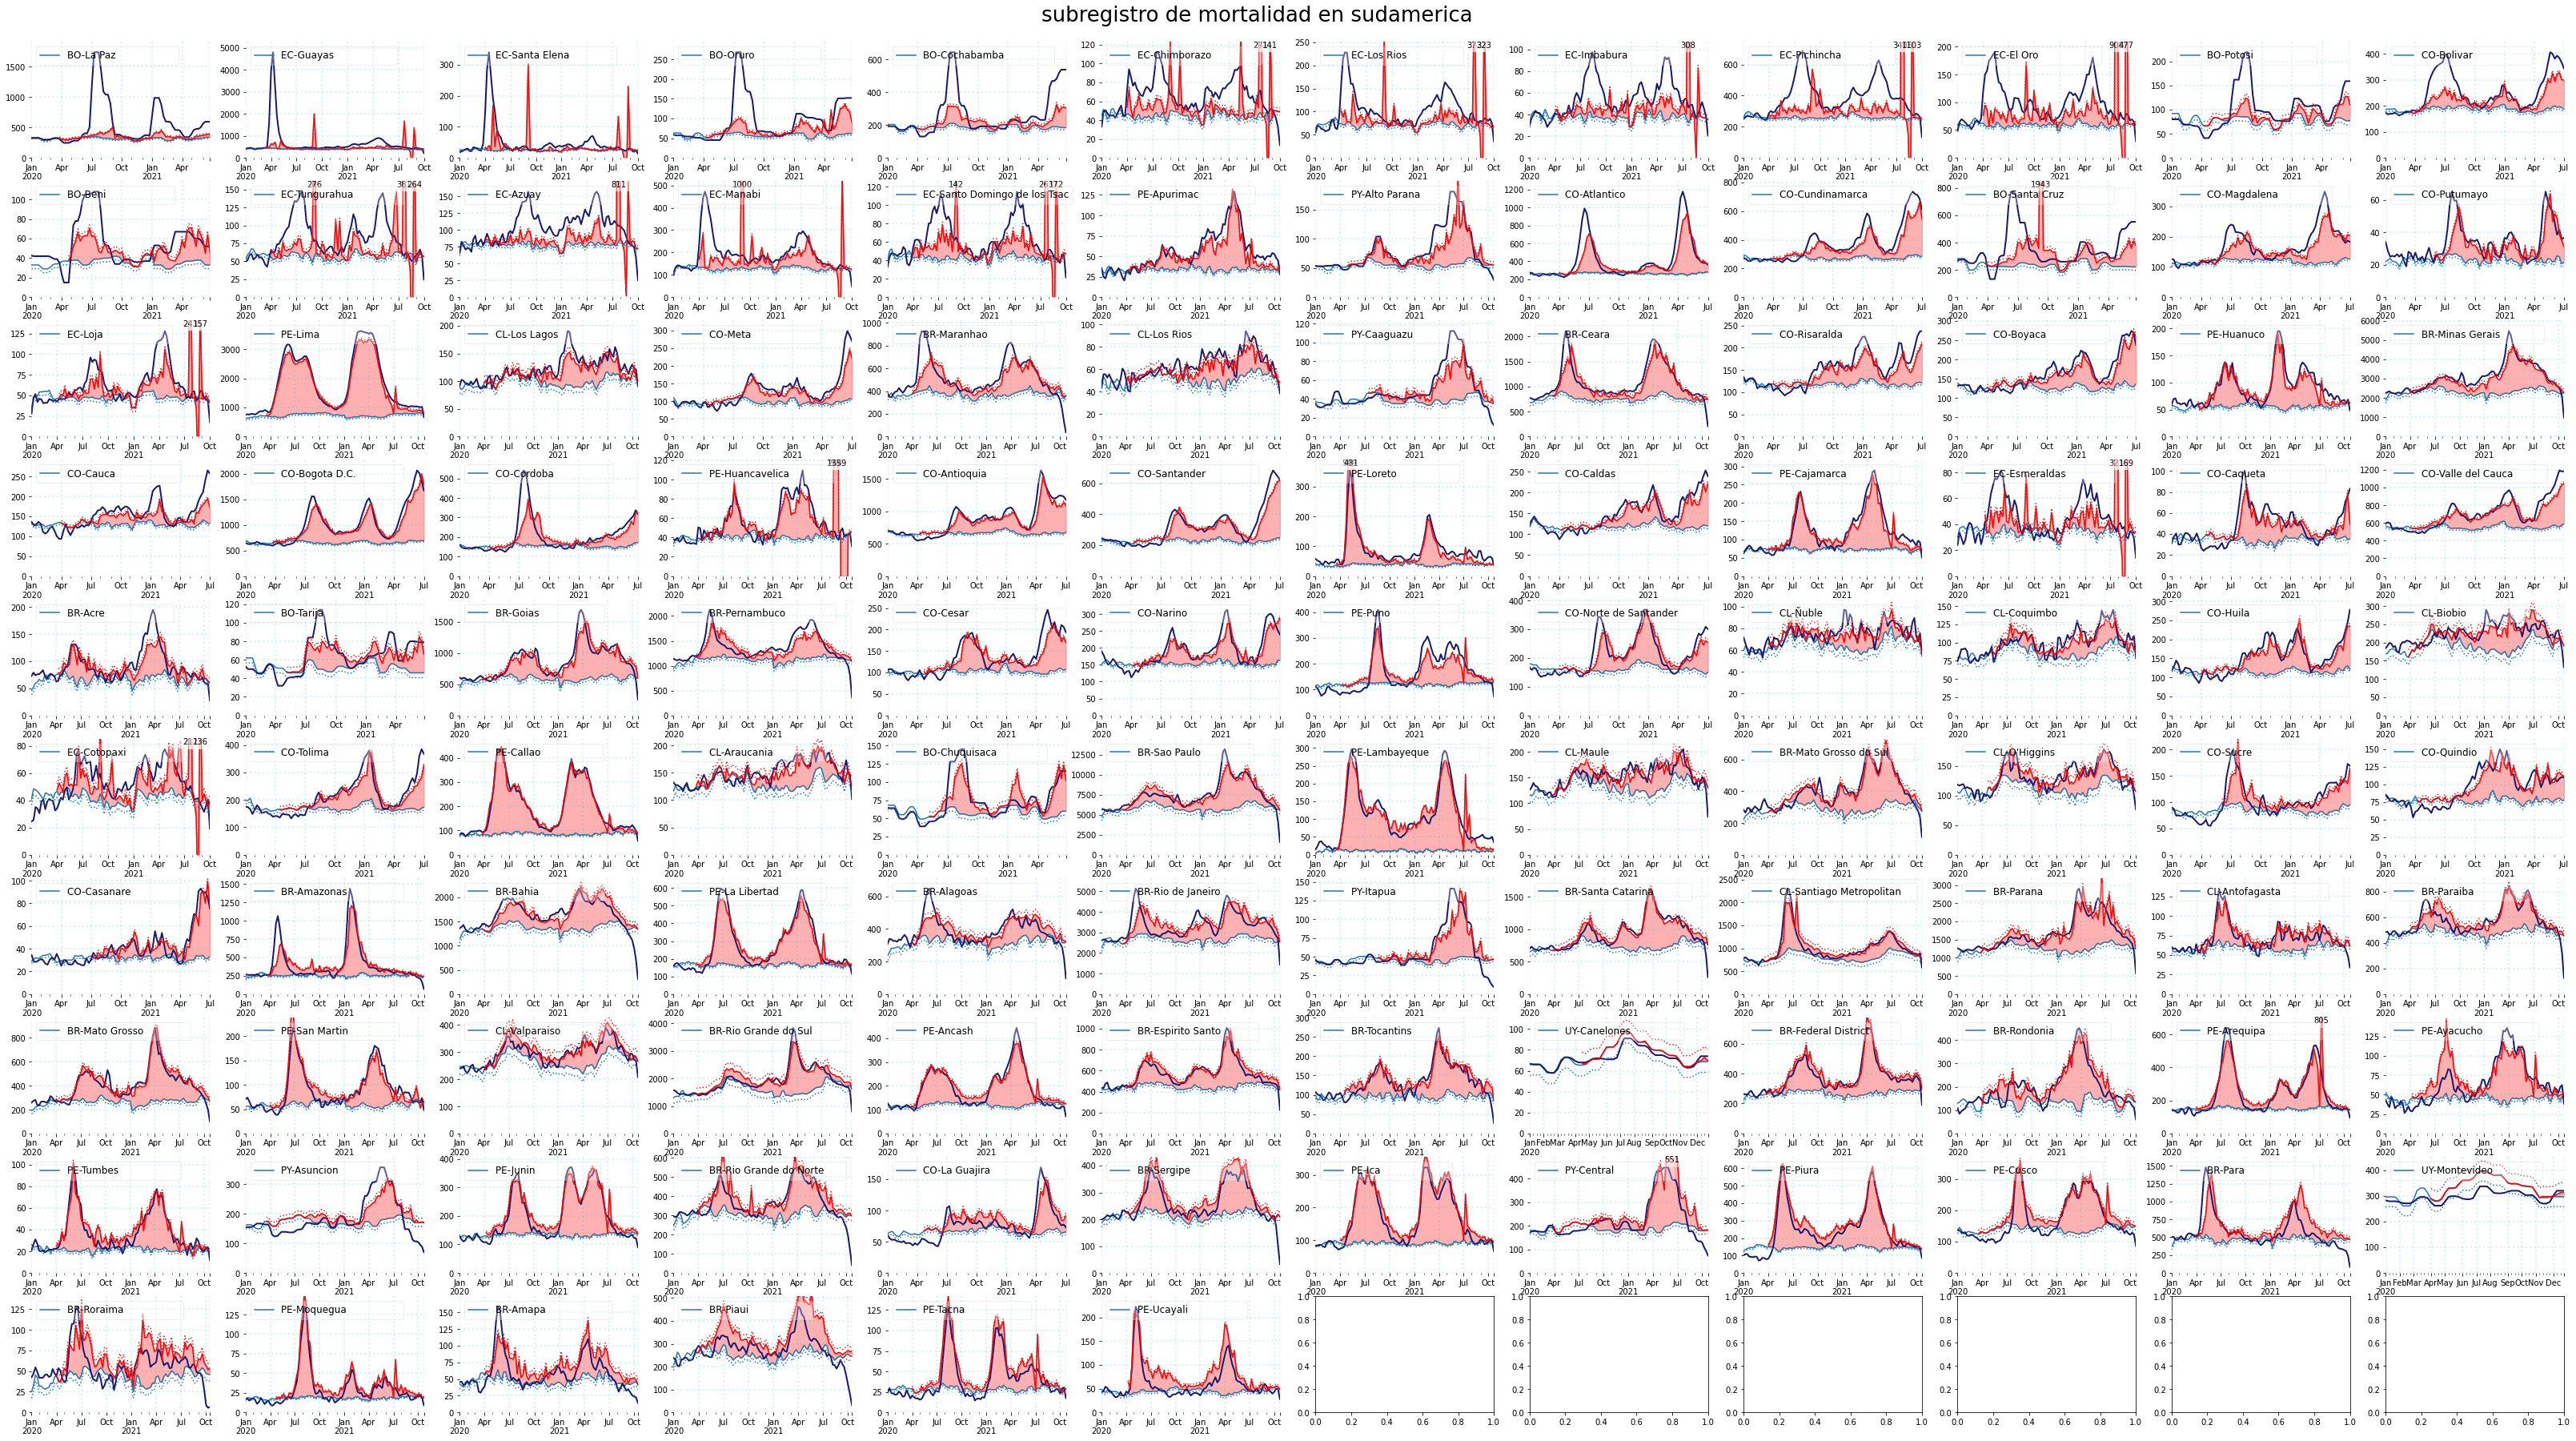

In [21]:
ncols = 12
nrows = np.ceil(len(mortality_df.columns) / ncols)

fig, axs = pyplot.subplots(
    ncols=ncols, 
    nrows=int(nrows), 
    figsize=(12 * ncols/2.54, 8 * nrows/2.54)
)
axs = axs.flatten()

for idx, item in enumerate(mortality_df.iteritems()):
    dept, covid_mortality_df = item
    
    covid_mortality_df = covid_mortality_df.dropna()
    registered_covid_df = covid_deaths_df[dept]
    
    do_plot(
        covid_mortality_df.rolling(window=2).mean().fillna(covid_mortality_df),
        registered_covid_df,
        ax=axs[idx]
    )
    
_ = fig.suptitle('subregistro de mortalidad en sudamerica', fontsize=26, y=.9)
fig.savefig('../img/mortality.subregistration.jpg', bbox_inches='tight')